<a href="https://colab.research.google.com/github/guilhermedossantos/TCC_NN_SARIMA/blob/master/teste2_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Primeiro teste de uma rede RNN em um SARIMA 

 - Foi gerado no R um processo $SARIMA(1,0,0)\times(1,0,0)$

In [0]:
#### SETUP ####
# Keras
from keras.models import Sequential # modelo
from keras.layers import Dense, SimpleRNN, LSTM, Reshape,Dropout # camadas
from keras.callbacks import EarlyStopping # early stopping

# scaler
from sklearn.preprocessing import MinMaxScaler

# Importação do arquivo 
from google.colab import files # upload de arquivos da máquina
import pandas_datareader as web # pacote bem interessante que pode valer a pena explorar (para importação de dados de diversar fontes)

# Gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats # usado no qq-plot
import plotly.tools as tls # para tentativa de converter mpl to plotly

# Removendo warnings
import warnings
warnings.filterwarnings('ignore') # tem também a opção 'once' para mostrar apenas uma vez

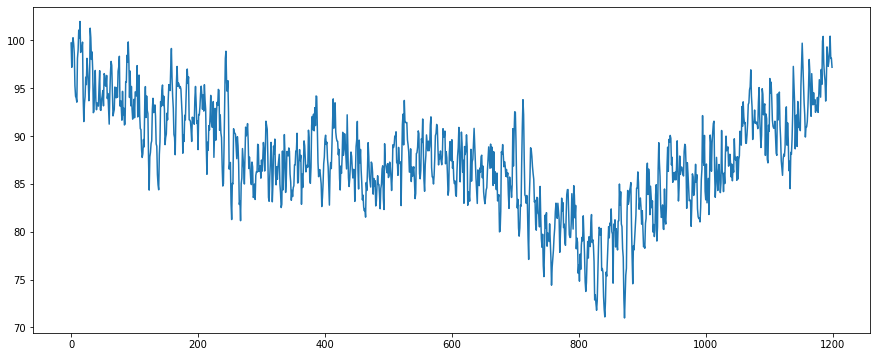

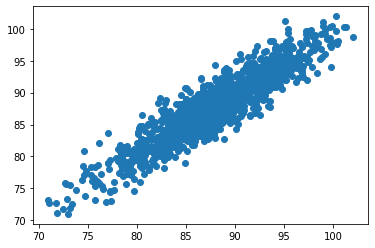

In [58]:
serie = pd.read_csv("https://raw.githubusercontent.com/guilhermedossantos/TCC_NN_SARIMA/master/serie_sarima.csv")
serie = serie + 100
serie = np.array(serie)
#serie
plt.figure(figsize = (15,6))
#plt.plot(serie[1:] - serie[:(len(serie) - 1)])
plt.plot(serie)

plt.figure()
plt.plot(serie[:(len(serie)-1)], serie[1:], 'o')


In [0]:
serie_original = serie

scaler = MinMaxScaler(feature_range=(0,1))
serie = scaler.fit_transform(serie_original)

# Função que transforma a série em uma matriz com k colunas (entradas da rede)
def convert_to_matrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)


k = 30
x, y = convert_to_matrix(serie,k)


In [0]:
x = x.reshape((-1,k,1))
treinox = x[0:(len(x) - 30)]
treinoy = y[0:(len(x) - 30)]
testex = x[(len(x) - 30):]
testey = y[(len(x) - 30):]


In [0]:
model = Sequential()
model.add(SimpleRNN(128, activation='tanh', input_shape = (k,1), return_sequences=True))
model.add(Dropout(0.2)) #, return_sequences = True))
model.add(SimpleRNN(128, activation='tanh', input_shape = (k,1)))
#model.add(LSTM(128, activation='relu', input_shape = (k,1)))
model.add(Dense(50, activation = "sigmoid"))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mape', 'mae', 'mse'])

In [62]:
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mape', 'mae', 'mse'])
history = model.fit(treinox, treinoy, epochs=5, validation_data=(testex, testey), verbose = 1)

Train on 1140 samples, validate on 30 samples
Epoch 1/5
1140/1140 [==============================] - 1s 847us/step - loss: 0.0310 - mape: 561223.0000 - mae: 0.1325 - mse: 0.0310 - val_loss: 0.0073 - val_mape: 7.6425 - val_mae: 0.0657 - val_mse: 0.0073
Epoch 2/5
1140/1140 [==============================] - 1s 527us/step - loss: 0.0092 - mape: 326695.0312 - mae: 0.0774 - mse: 0.0092 - val_loss: 0.0111 - val_mape: 10.2554 - val_mae: 0.0873 - val_mse: 0.0111
Epoch 3/5
1140/1140 [==============================] - 1s 524us/step - loss: 0.0082 - mape: 238319.8281 - mae: 0.0729 - mse: 0.0082 - val_loss: 0.0066 - val_mape: 7.4114 - val_mae: 0.0633 - val_mse: 0.0066
Epoch 4/5
1140/1140 [==============================] - 1s 516us/step - loss: 0.0081 - mape: 282244.4688 - mae: 0.0722 - mse: 0.0081 - val_loss: 0.0188 - val_mape: 14.6803 - val_mae: 0.1228 - val_mse: 0.0188
Epoch 5/5
1140/1140 [==============================] - 1s 555us/step - loss: 0.0066 - mape: 152701.4688 - mae: 0.0651 - mse: 0.0

In [0]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

30/30 [==============================] - 0s 205us/step


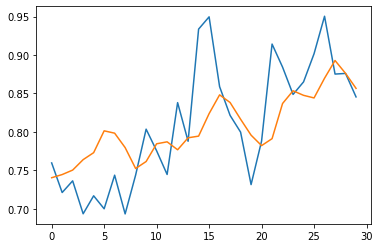

In [63]:
model.evaluate(testex, testey)

plt.plot(testey)
plt.plot(model.predict(testex))

In [64]:
preds = model.predict(testex)
preds_original = scaler.inverse_transform(preds)

y_original = scaler.inverse_transform(testey)

mape = np.mean(abs((y_original - preds_original)/abs(y_original))*100)
mae = np.mean(abs(y_original - preds_original))
mse = np.mean((y_original - preds_original)**2)


print("MAPE com prev. 1 passo a frente: {}%".format(round(mape,3)))
print("MSE com prev. 1 passo a frente: {}".format(round(mse)))
print("MAE com prev. 1 passo a frente: {}".format(round(mae,3)))
print("Vício: {}".format(np.mean(preds_original - y_original).round(3)))

#plt.figure(figsize=(15,6))
#plt.plot(y_original)
#plt.plot(preds_original)


MAPE com prev. 1 passo a frente: 1.425%
MSE com prev. 1 passo a frente: 3.0
MAE com prev. 1 passo a frente: 1.375
Vício: -0.132


In [0]:
#plt.plot(abs((y_original - preds_original)/abs(y_original))*100, 'o')

#np.mean([x for x in abs((y_original - preds_original)/abs(y_original))*100 if x <80])

Previsão vários passos a frente

MAPE: 1.948%
MAE: 1.874
MSE: 5.25
Vício: 0.031


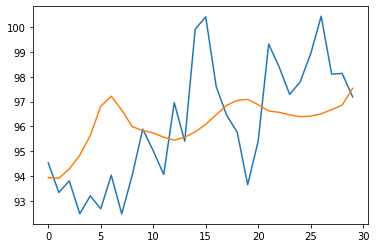

In [65]:
#y_pred = np.zeros(testey.shape)
#for i in range(len(testey)-1):
#  if i == 0:
#    y_pred[0] = model.predict(testex[0].reshape(1,k,1))
#    testex[1] = np.append(testex[0, 1:k], y_pred[0]).reshape((k,1))
#  else:
#    y_pred[i] = model.predict(testex[i].reshape(1,k,1)).reshape((1,))
#    testex[i+1] = np.append(testex[i, 1:k], y_pred[i]).reshape((k,1))

testex2 = testex.copy() #AJEITAR ISSO AQUI PQ N TA PEGANDO O ÚLTIMO ÍNDICE
for i in range(len(testey)-1):
  if i == 0:
    ypred = model.predict(testex2[0].reshape(1,k,1)).reshape(1,)
    testex2[1] = np.append(testex2[0, 1:k], ypred).reshape(k,1)
  else:
    ypred = np.append(ypred, model.predict(testex2[i].reshape(1,k,1)).reshape(1,))  
    testex2[i+1] = np.append(testex2[i, 1:k], ypred[i]).reshape(k,1)

ypred = np.append(ypred, model.predict(testex[-1].reshape(1,k,1)).reshape(1,))  


preds_original = scaler.inverse_transform(ypred.reshape((-1,1)))

y_original = scaler.inverse_transform(testey)

mape = np.mean(abs((y_original - preds_original)/abs(y_original))*100)
mae = np.mean(abs(y_original - preds_original))
mse = np.mean((y_original - preds_original)**2)

print("MAPE: " + str(round(mape,3)) + "%")
print("MAE: " + str(round(mae,3)))
print("MSE: " + str(round(mse,3)))
print("Vício: {}".format(np.mean(preds_original - y_original).round(3)))

plt.plot(y_original)
plt.plot(preds_original)

#plt.figure()
#plt.plot(ypred)
#plt.plot(testey)

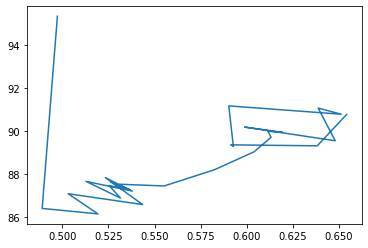

In [32]:
#testex[:,12]
#plt.plot(ypred[:29], preds_original[1:])
